***This notebook shall only be run on colab***

`Trained ON - Tesla T4 GPU`

#### !Results produced by GPU tend to be non-deterministic due to some non-deterministic opeartions in the GPU

In [2]:
!python --version
!mkdir results

from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Major Project Stuff/Implementation/dataset.zip" -d /content/
print("dataset extracted\n\n")

!pip install xgboost

Python 3.12.12
Mounted at /content/drive
dataset extracted




In [3]:
import glob, os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
import torch
from transformers import ViTImageProcessor, ViTModel
import torchvision.models as models
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.models import ResNet50_Weights

In [11]:
d=""
if torch.cuda.is_available():
    d="cuda"
else:
    d="cpu"

device=torch.device(d)
print(f"USING DEVICE :: {device}")

manual_seed = 250 # set a manual seed for reproducibility of results

if d=="cuda":
    torch.cuda.manual_seed(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Device name:: {torch.cuda.get_device_name(0)}")  # GPU model
else:
    torch.manual_seed(manual_seed)
print("Manual seed set to ",manual_seed)

USING DEVICE :: cuda
Device name:: Tesla T4
Manual seed set to  250


### Loading pretrained models

In [12]:
# Load ViT
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
vit_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [13]:
# Load ResNet50
weights_resnet = ResNet50_Weights.DEFAULT
cnn_model = models.resnet50(weights=weights_resnet)
cnn_model = torch.nn.Sequential(*list(cnn_model.children())[:-1]).to(device)  # remove final classifier
cnn_model.eval()

# use the transform associated with the weights
transform_cnn = weights_resnet.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [14]:
# Load MobilNetV3 Large
weights_mobilenet = MobileNet_V3_Large_Weights.DEFAULT
mobilenet_model = models.mobilenet_v3_large(weights=weights_mobilenet)
# keep feature extractor only
mobilenet_model = nn.Sequential(*list(mobilenet_model.children())[:-1]).to(device)
mobilenet_model.eval()

# use the transform associated with the weights
transform_mobilenet = weights_mobilenet.transforms()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 196MB/s]


### Implementing feature extraction and attention based feature fusion class

In [15]:
# feature extraction function for each dl

def extract_cnn_features(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform_cnn(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = cnn_model(img_tensor)  # shape [1, 2048, 1, 1]
    return features.view(-1).cpu().numpy().astype(np.float32)# shape [2048,]

def extract_mobilenet_features(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform_mobilenet(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = mobilenet_model(img_tensor)  # [1, 960, H, W] for MobileNetV3-Large
        features = F.adaptive_avg_pool2d(features, (1, 1))  # [1, 960, 1, 1]

    return features.view(-1).cpu().numpy().astype(np.float32) # shape [960,]

def extract_vit_features(image_path):
    """Extract 1-D CLS embedding from a single image using ViT."""
    image = Image.open(image_path).convert('RGB')
    inputs = image_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = vit_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token

    return cls_embedding.squeeze().cpu().numpy().astype(np.float32)  # shape [768,]


In [16]:
# proposed fusion model
class AttentionFusion(nn.Module):
    def __init__(self, d_cnn=2048, d_mbnt=960, d_vit=768, d_out=512):
        super(AttentionFusion, self).__init__()
        # projection layers for each backbone
        self.fc_cnn = nn.Linear(d_cnn, d_out).to(device)
        self.fc_mbnt = nn.Linear(d_mbnt, d_out).to(device)
        self.fc_vit = nn.Linear(d_vit, d_out).to(device)

    def forward(self, f_cnn, f_mbnt, f_vit):
        # normalize before projection
        f_cnn = F.normalize(torch.tensor(f_cnn, dtype=torch.float32, device=device), p=2, dim=0)
        f_mbnt = F.normalize(torch.tensor(f_mbnt, dtype=torch.float32, device=device), p=2, dim=0)
        f_vit = F.normalize(torch.tensor(f_vit, dtype=torch.float32, device=device), p=2, dim=0)

        f_cnn = self.fc_cnn(f_cnn)
        f_mbnt = self.fc_mbnt(f_mbnt)
        f_vit = self.fc_vit(f_vit)



        ### deterministic weights based on feature entropy ###

        # compute entropy of each feature vector
        def entropy_weight(x):
            p = torch.abs(x) / torch.sum(torch.abs(x))  # normalize to a distribution
            return -torch.sum(p * torch.log(p + 1e-8))

        entropies = torch.stack([
            entropy_weight(f_cnn),
            entropy_weight(f_mbnt),
            entropy_weight(f_vit)
        ], dim=0).detach().to(device)

        # softmax normalization
        weights = torch.softmax(entropies, dim=0)

        # weighted concatenation of projected features
        fused = torch.cat([
            weights[0] * f_cnn,
            weights[1] * f_mbnt,
            weights[2] * f_vit
        ], dim=0)

        return fused.detach().cpu().numpy()  # back to CPU for sklearn


fusion_model = AttentionFusion().to(device)

In [17]:
# extract features from each model and insert it into our proposed fusion model

def extract_fused_features(image_path):
    f_cnn = extract_cnn_features(image_path)
    f_mbnt = extract_mobilenet_features(image_path)
    f_vit = extract_vit_features(image_path)
    fused = fusion_model(f_cnn, f_mbnt, f_vit)
    return fused

### Loading dataset

In [18]:

def build_dataset(data_dir):
    dataset = []
    classes = os.listdir(data_dir)   # ['benign', 'malignant']
    for cls in classes:
        img_paths = glob.glob(os.path.join(data_dir, cls, "*.jpg"))
        for p in img_paths:
            dataset.append((p, cls))
    return dataset

train_dataset = build_dataset("/content/dataset/train")
test_dataset = build_dataset("/content/dataset/test")

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 12242
Test samples: 1660


### Extracting test and train features

In [ ]:
# train set
train_features, train_labels = [], []
for img_path, label in train_dataset:
    fused_feat = extract_fused_features(img_path)
    train_features.append(fused_feat)
    train_labels.append(label)

X_train = np.array(train_features)
y_train = np.array(train_labels)

In [ ]:
# test set
test_features, test_labels = [], []
for img_path, label in test_dataset:
    fused_feat = extract_fused_features(img_path)
    test_features.append(fused_feat)
    test_labels.append(label)

X_test = np.array(test_features)
y_test = np.array(test_labels)

In [ ]:
np.save("/content/X_train.npy", X_train)
np.save("/content/y_train.npy", y_train)

In [ ]:
np.save("/content/X_test.npy", X_test)
np.save("/content/y_test.npy", y_test)

### Loading saved test and train features

In [ ]:
"""
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")"""

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Defining base classifiers and the ensemble

In [ ]:
# ensemble
from sklearn.pipeline import Pipeline

maxIterations = 1000
randomState = 42
nEstimators = 250
nNeighbors = 11

clf1 = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=maxIterations, random_state=randomState))
    ])
clf2 = RandomForestClassifier(n_estimators=nEstimators, random_state=randomState)
clf3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, kernel='rbf', random_state=randomState))
])
clf4 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=nNeighbors))
])
clf5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=randomState)


# soft voting ensemble
ensemble = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('svm', clf3), ('knn', clf4), ('xgb', clf5)
], voting='soft')


### Training the ensemble

In [ ]:
ensemble.fit(X_train, y_train_encoded)
print("Ensemble training complete.")

### Result

In [ ]:
import pandas as pd # for saving data

In [ ]:
# predictions
y_pred = ensemble.predict(X_test)

print("\tENSEMBLE ACCURACY:", accuracy_score(y_test_encoded, y_pred))

# classsification report - ensemble
print("\n\tClassification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# CM
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Ensemble)")
plt.show()


print("\n\n\tACCURACY OF INDIVIDUAL CLASSIFIERS\n")
classifiers = {
    "Logistic Regression": clf1,
    "Random Forest": clf2,
    "SVM (RBF)": clf3,
    "KNN": clf4,
    "XGBoost": clf5
}

individual_acc = []
for name, model in classifiers.items():
    model.fit(X_train, y_train_encoded)
    y_pred_ = model.predict(X_test)

    acc = accuracy_score(y_test_encoded, y_pred_)

    individual_acc.append((name,acc))
    print("\t---------------------------------------")
    print(f"\t{name} Accuracy: {acc:.4f}\n")
    print(classification_report(y_test_encoded, y_pred_, target_names=label_encoder.classes_))
    print("\t---------------------------------------\n\n")

    # save the report for each classifier
    report_dict = classification_report(y_test_encoded, y_pred_, target_names=label_encoder.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(f"/content/results/{name}_report.csv", index=True)

In [ ]:
# save the CM
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Ensemble)")
plt.savefig("/content/results/cm.png", dpi=300, bbox_inches="tight")
plt.close()

In [ ]:
# save ensemble report
report_dict = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("/content/results/ensemble_classification_report.csv", index=True)

In [ ]:
# save accuracy of each classifier
print(individual_acc)
accuracy_df = pd.DataFrame(individual_acc)
accuracy_df.to_csv("/content/results/individual_classifier_accuracies.csv", index=False)

## Dataset decsription - Average value of the pixels
---
### Line plots of the average histograms of all the train images (class-wise)

- Reveals contrast variation information between the groups (narrow vs wide histograms)

- Reveals overall darkness/brightness comparision between malignant and benign images (shift in peaks observed in the obtained images)

Looking at the plot:

Malignant images (red) show a strong spike near intensity 0. Thi these images contain a lot more very dark pixels, likely from heavily pigmented lesion areas, hair, or shadows.

Benign images (blue) have higher frequencies at the mid-high intensity range (150-220) → these lesions are generally lighter, with more skin-colored regions visible.

Both curves taper off at the extreme right (>240), meaning very bright pixels are rare in both classes.

***Overall, this graph conveys that in our dataset, malignant lesions tend to be darker and more pigmented, while benign lesions are lighter on average***

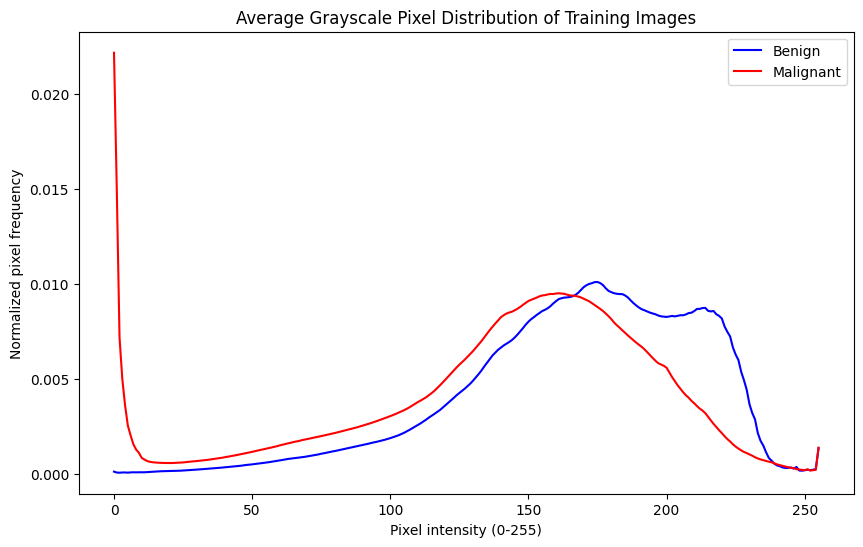

In [ ]:
import cv2

def compute_average_histogram(folder_path):
    hist_list = []
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.jpg'):
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            hist = cv2.calcHist([img], [0], None, [256], [0, 256])
            hist = hist.flatten()
            hist /= img.size
            hist_list.append(hist)
    avg_hist = np.mean(hist_list, axis=0)
    return avg_hist

def plot_average_histograms(folder1, folder2, label1='Folder 1', label2='Folder 2'):
    avg_hist1 = compute_average_histogram(folder1)
    avg_hist2 = compute_average_histogram(folder2)

    plt.figure(figsize=(10,6))
    plt.plot(avg_hist1, color='blue', label=label1)
    plt.plot(avg_hist2, color='red', label=label2)
    plt.title("Average Grayscale Pixel Distribution of Training Images")
    plt.xlabel("Pixel intensity (0-255)")
    plt.ylabel("Normalized pixel frequency")
    plt.legend()
    plt.show()

train_benign = "/content/dataset/train/benign"
train_malignant = "/content/dataset/train/malignant"

plot_average_histograms(train_benign, train_malignant, label1='Benign', label2='Malignant')